In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from textdistance import length


Importing and cleaning the data

C:\Users\galzw\AppData\Local\Temp\ipykernel_11380\3850601581.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ocean_data20 = pd.read_csv(url1, delim_whitespace=True, skiprows=[1])
C:\Users\galzw\AppData\Local\Temp\ipykernel_11380\3850601581.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ocean_data21 = pd.read_csv(url2, delim_whitespace=True, skiprows=[1])
C:\Users\galzw\AppData\Local\Temp\ipykernel_11380\3850601581.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ocean_data22 = pd.read_csv(url3, delim_whitespace=True, skiprows=[1])
C:\Users\galzw\AppData\Local\Temp\ipykernel_11380\3850601581.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be rem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44345 entries, 0 to 44344
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   #YY     44345 non-null  int64  
 1   MM      44345 non-null  int64  
 2   DD      44345 non-null  int64  
 3   hh      44345 non-null  int64  
 4   mm      44345 non-null  int64  
 5   WDIR    44345 non-null  int64  
 6   WSPD    44345 non-null  float64
 7   GST     44345 non-null  float64
 8   WVHT    44345 non-null  float64
 9   DPD     44345 non-null  float64
 10  APD     44345 non-null  float64
 11  MWD     44345 non-null  int64  
 12  PRES    44345 non-null  float64
 13  ATMP    44345 non-null  float64
 14  WTMP    44345 non-null  float64
 15  DEWP    44345 non-null  float64
 16  VIS     44345 non-null  float64
 17  TIDE    44345 non-null  float64
dtypes: float64(11), int64(7)
memory usage: 6.1 MB


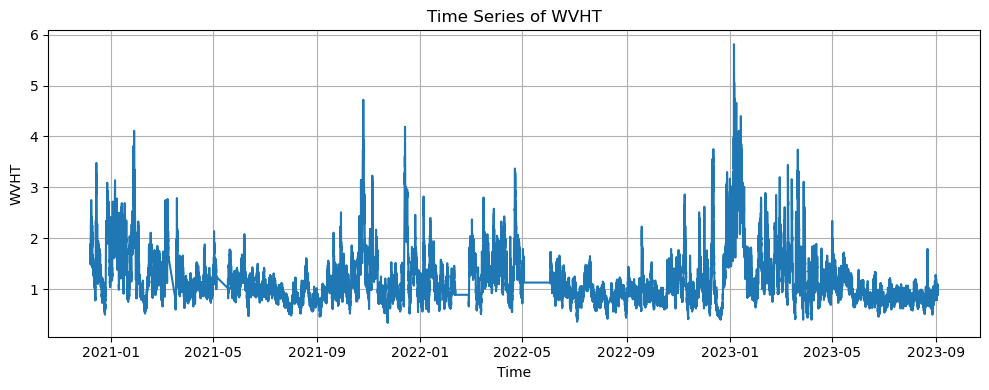

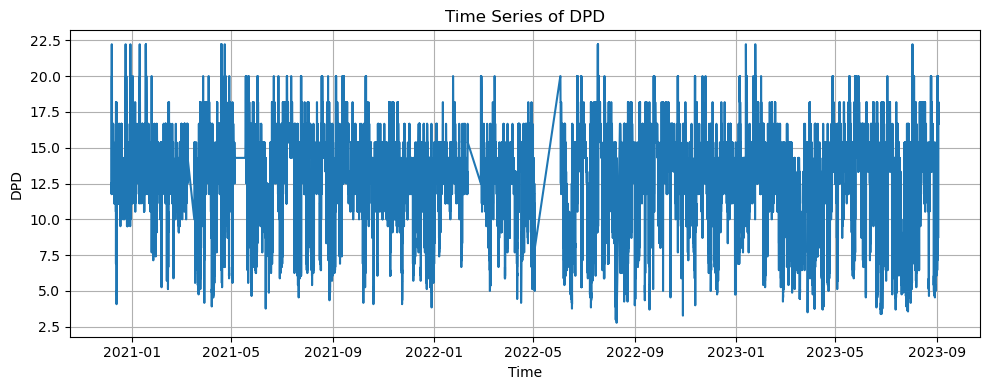

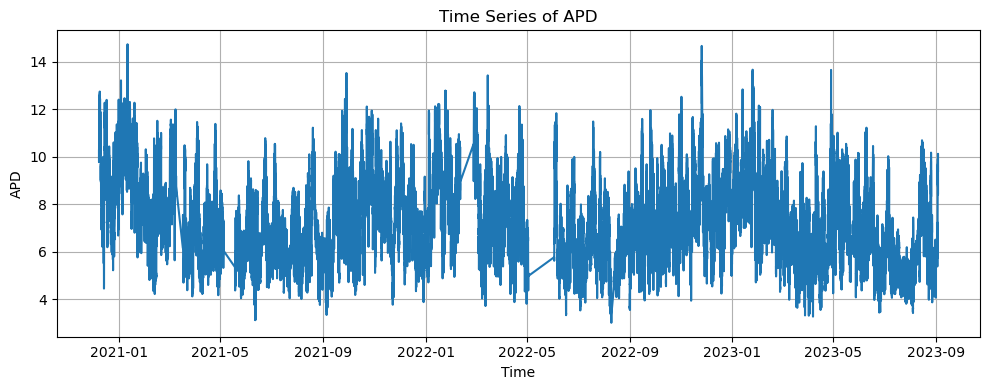

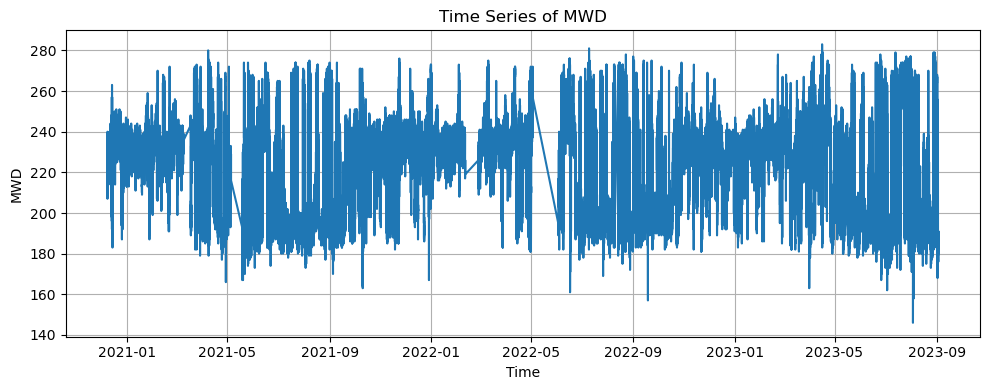

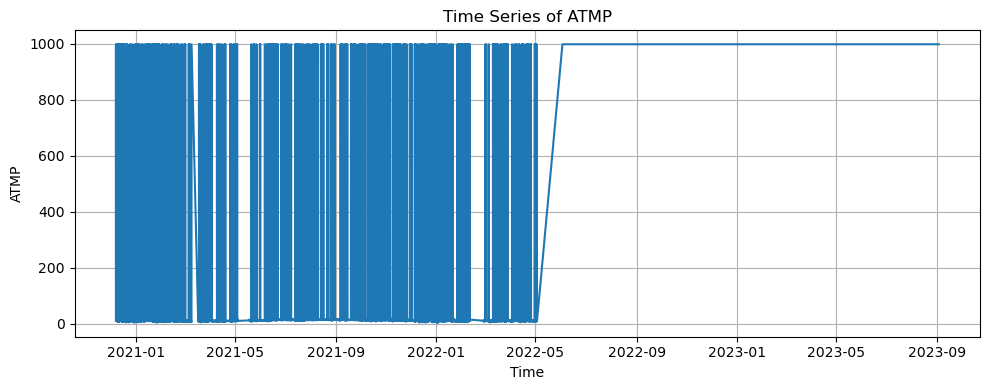

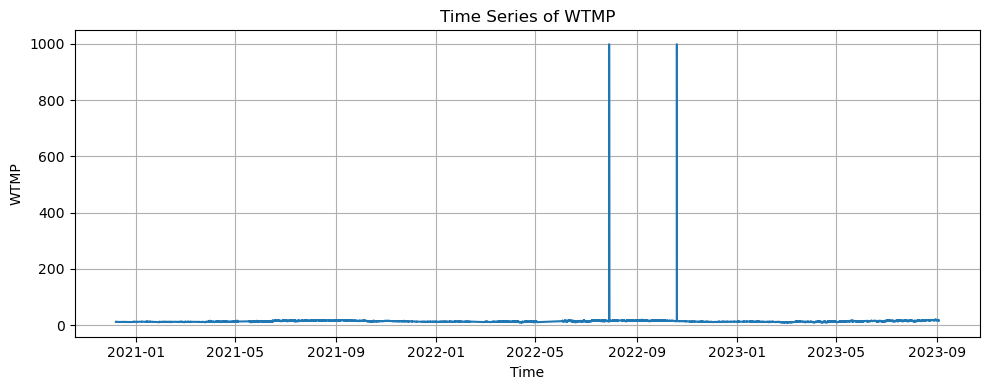

In [2]:
url1 = "https://www.ndbc.noaa.gov/view_text_file.php?filename=46269h2020.txt.gz&dir=data/historical/stdmet/"
url2 = "https://www.ndbc.noaa.gov/view_text_file.php?filename=46269h2021.txt.gz&dir=data/historical/stdmet/"
url3 = "https://www.ndbc.noaa.gov/view_text_file.php?filename=46269h2022.txt.gz&dir=data/historical/stdmet/"
url4 = "https://www.ndbc.noaa.gov/view_text_file.php?filename=46269h2023.txt.gz&dir=data/historical/stdmet/"
ocean_data20 = pd.read_csv(url1, delim_whitespace=True, skiprows=[1])
ocean_data21 = pd.read_csv(url2, delim_whitespace=True, skiprows=[1])
ocean_data22 = pd.read_csv(url3, delim_whitespace=True, skiprows=[1])
ocean_data23 = pd.read_csv(url4, delim_whitespace=True, skiprows=[1])


ocean_data = pd.concat([ocean_data20, ocean_data21, ocean_data22, ocean_data23], ignore_index=True)

ocean_data.head()
ocean_data.info()
ocean_data.describe()

#transferring to time series format
ocean_data['datetime'] = pd.to_datetime(ocean_data[['#YY','MM','DD','hh','mm']].rename(columns={'#YY': 'year', 'MM': 'month', 'DD': 'day', 'hh': 'hour', 'mm': 'minute'}))
ocean_data.set_index('datetime', inplace=True)

#dropping the date time columns and only-NA columns
ocean_data.drop(columns=['#YY', 'MM', 'DD', 'hh', 'mm','WDIR','WSPD','GST','PRES','DEWP','VIS','TIDE'], inplace=True)

#plotting all variables to search for artifacts
for col in ocean_data.columns:

    plt.figure(figsize=(10, 4))
    plt.plot(ocean_data.index, ocean_data[col])
    plt.title(f"Time Series of {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We can see suspicious behaviour in WVHT, DPD, APD, MWD between february to beginning of march  and may to beginning of june
We'll first take a look at that are and then go on to the other columns

First indentify the suspicious area

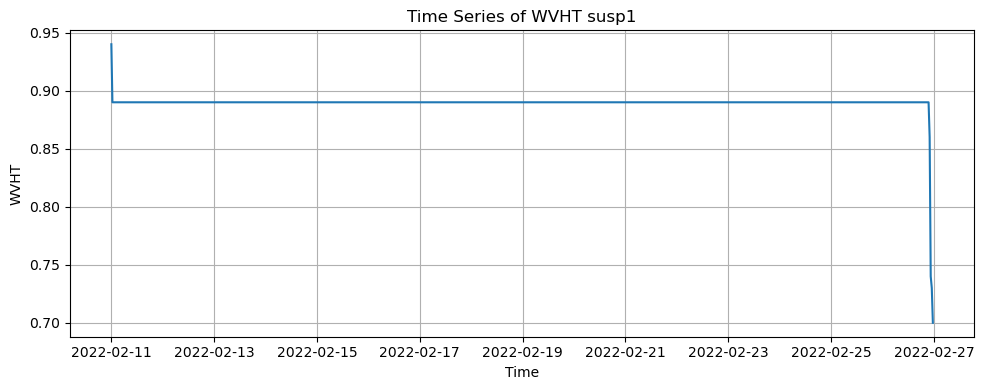

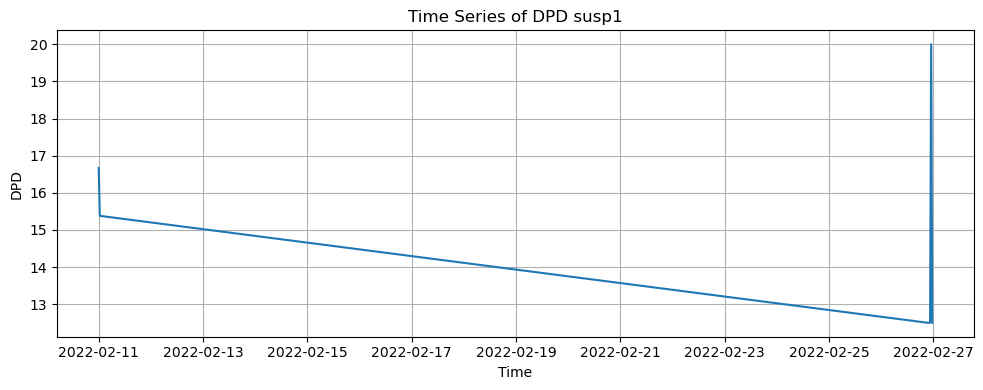

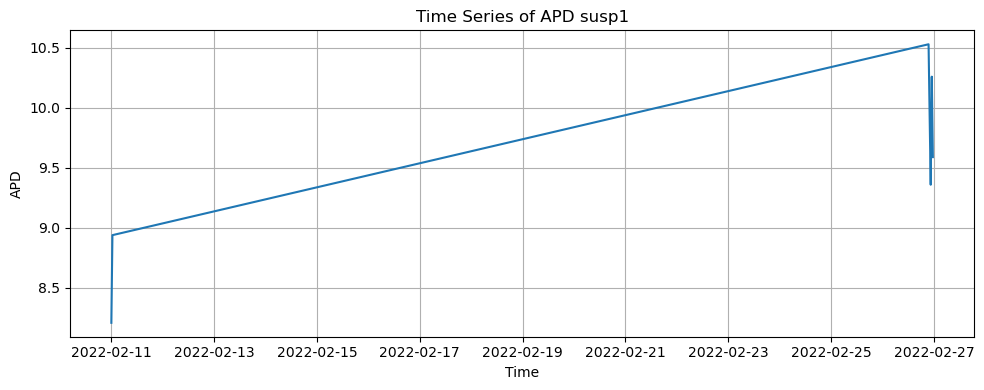

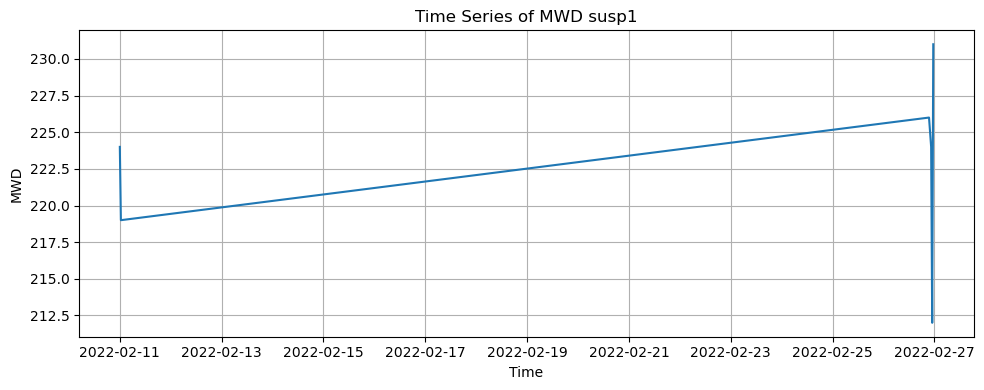

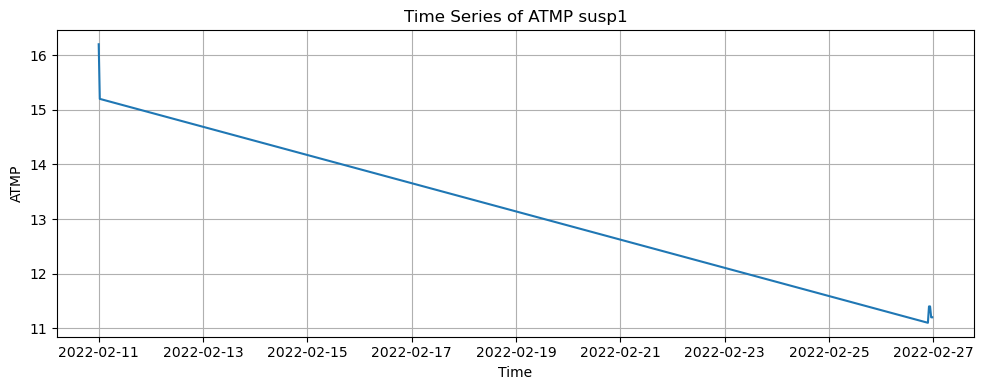

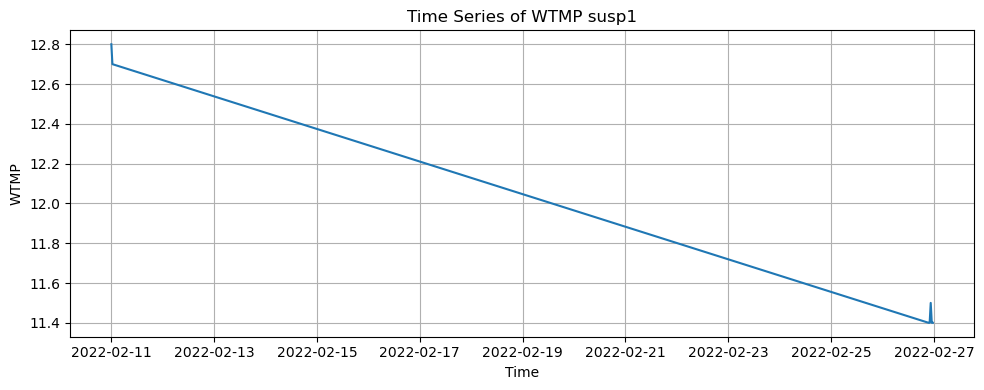

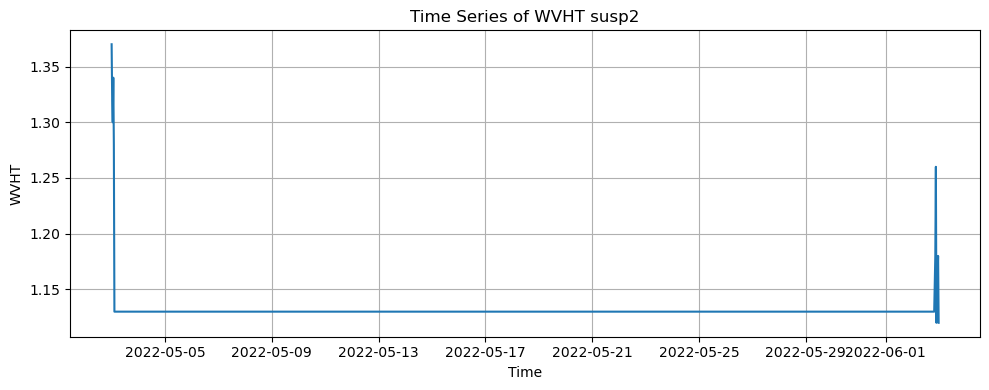

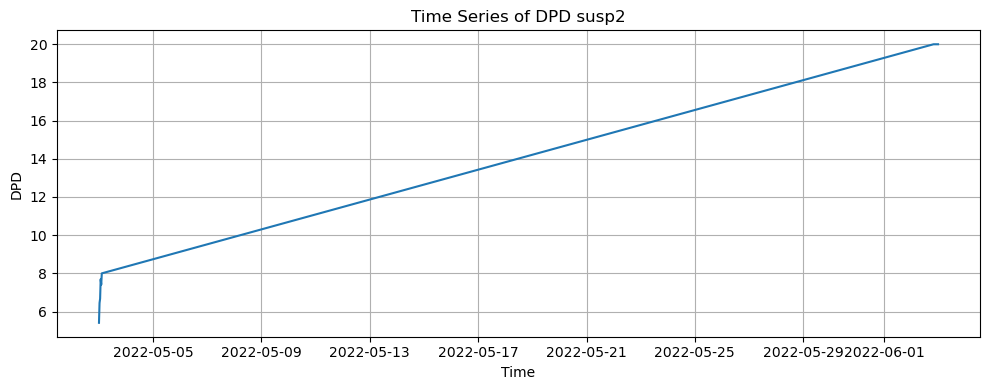

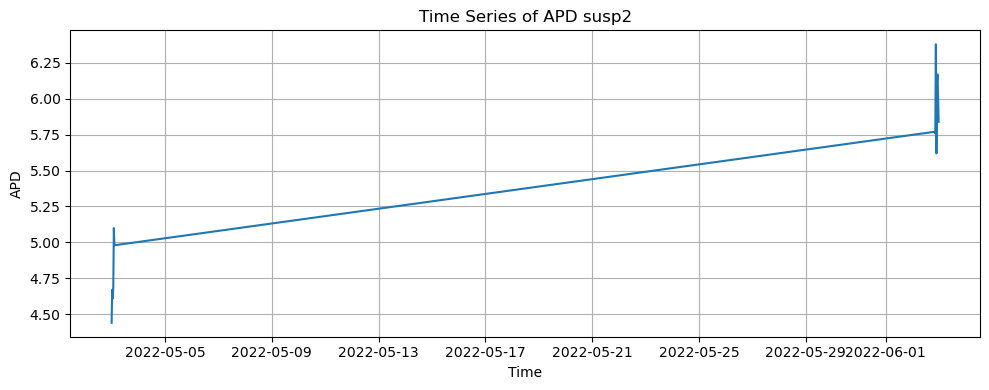

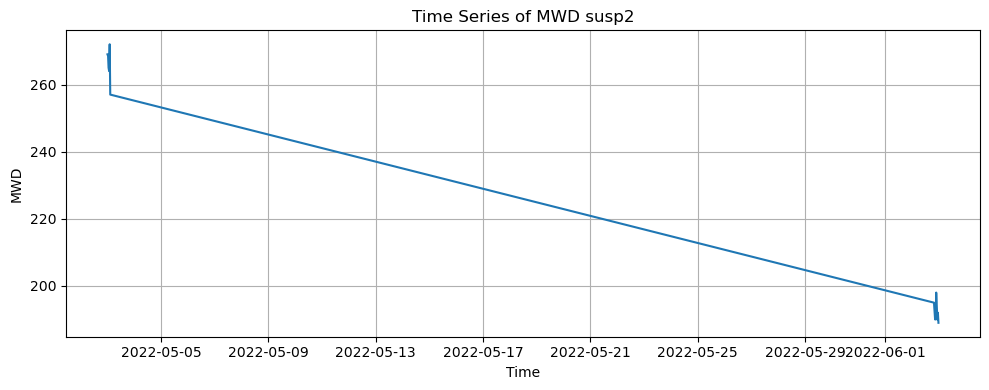

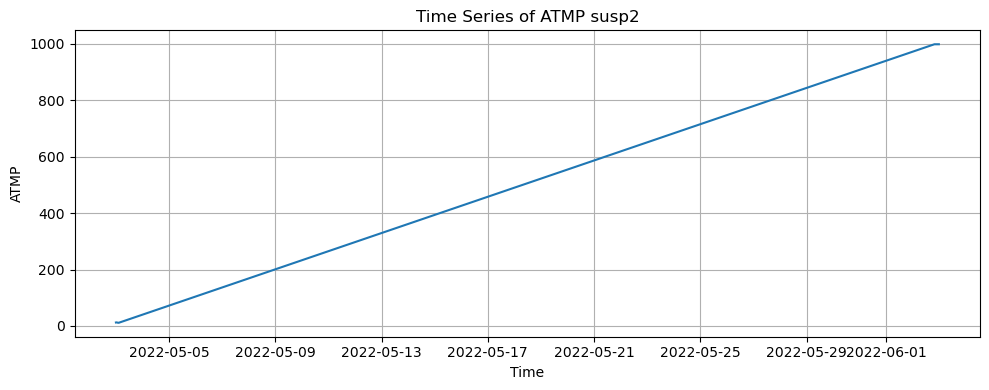

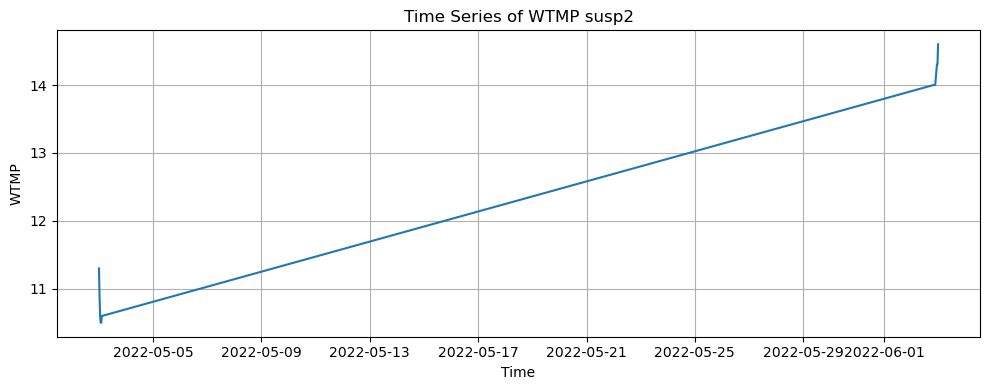

In [3]:
ocean_data_susp1 = ocean_data['2022-02-11' : '2022-02-26']
ocean_data_susp2 = ocean_data['2022-05-03' : '2022-06-02']


for col in ocean_data_susp1.columns:

    plt.figure(figsize=(10, 4))
    plt.plot(ocean_data_susp1.index, ocean_data_susp1[col])
    plt.title(f"Time Series of {col} susp1")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



for col in ocean_data_susp2.columns:

    plt.figure(figsize=(10, 4))
    plt.plot(ocean_data_susp2.index, ocean_data_susp2[col])
    plt.title(f"Time Series of {col} susp2")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Now we'll look at those areas closer, we'll see that there are several dates who are missing, we'll fill those gaps with NA values.
We will also make sure that all the other non numeric data is NA

In [4]:
print(ocean_data_susp1)
print(ocean_data_susp2)

full_index = pd.date_range(start=ocean_data.index.min(), end=ocean_data.index.max(), freq='30min')
ocean_data = ocean_data.reindex(full_index)

ocean_data.apply(pd.to_numeric, errors='coerce')

                     WVHT    DPD    APD  MWD  ATMP  WTMP
datetime                                                
2022-02-11 00:00:00  0.94  16.67   8.21  224  16.2  12.8
2022-02-11 00:30:00  0.89  15.38   8.94  219  15.2  12.7
2022-02-26 21:30:00  0.89  12.50  10.53  226  11.1  11.4
2022-02-26 22:00:00  0.86  12.50   9.93  225  11.4  11.4
2022-02-26 22:30:00  0.74  12.50   9.36  224  11.4  11.5
2022-02-26 23:00:00  0.73  20.00  10.26  212  11.2  11.4
2022-02-26 23:30:00  0.70  12.50   9.59  231  11.2  11.4
                     WVHT    DPD   APD  MWD   ATMP  WTMP
datetime                                                
2022-05-03 00:00:00  1.37   5.41  4.44  269   12.4  11.3
2022-05-03 00:30:00  1.32   6.45  4.67  269   12.7  10.9
2022-05-03 01:00:00  1.30   6.67  4.61  265   12.4  10.6
2022-05-03 01:30:00  1.34   7.69  4.69  264   11.8  10.5
2022-05-03 02:00:00  1.28   7.41  5.10  272   11.5  10.5
2022-05-03 02:30:00  1.13   8.00  4.98  257   11.3  10.6
2022-06-02 19:30:00  1.13  20.0

,WVHT,DPD,APD,MWD,ATMP,WTMP
2020-12-07 22:00:00,1.86,12.50,10.25,237.0,12.6,11.7
2020-12-07 22:30:00,1.77,22.22,10.42,207.0,999.0,11.7
2020-12-07 23:00:00,1.65,12.50,9.77,234.0,18.5,11.7
2020-12-07 23:30:00,1.79,22.22,10.17,212.0,16.3,11.7
2020-12-08 00:00:00,1.77,11.76,10.45,240.0,19.3,11.7
...,...,...,...,...,...,...
2023-09-02 19:30:00,0.97,16.67,9.23,177.0,999.0,17.5
2023-09-02 20:00:00,1.09,16.67,10.12,180.0,999.0,17.6
2023-09-02 20:30:00,0.93,16.67,8.41,182.0,999.0,17.7
2023-09-02 21:00:00,0.98,16.67,8.95,191.0,999.0,17.3


Now we'll look at ATMP(air temperature) and WTMP(water temperature). ATMP has a weird behaviour all over, and WTMP has 2 huge bumps that looks like an NA/mistake that we will remove

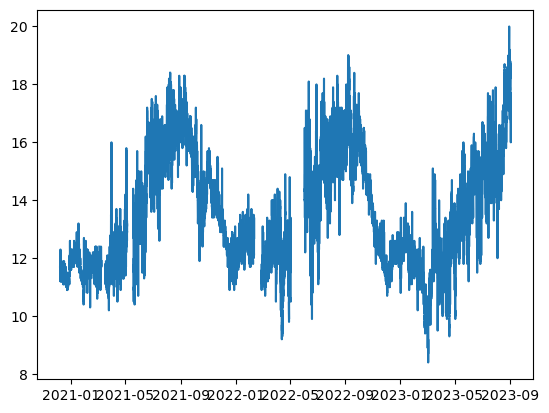

In [5]:
art_wtmp = ocean_data['WTMP'].max()

ocean_data.apply(pd.to_numeric, errors='coerce')

ocean_data.loc[ocean_data['WTMP'] == art_wtmp, 'WTMP'] = np.NaN

plt.plot(ocean_data.index, ocean_data['WTMP'])
plt.show()

Now we'll try to look at ATMP weird behaviour

In [6]:
ocean_data['ATMP'].value_counts()
#We can see again that 999 probably signifies na
art_wtmp = ocean_data['ATMP'].max()

ocean_data.loc[ocean_data['ATMP'] == art_wtmp, 'ATMP'] = np.NaN

Lets try to visualize the data again to see if it looks cleaner

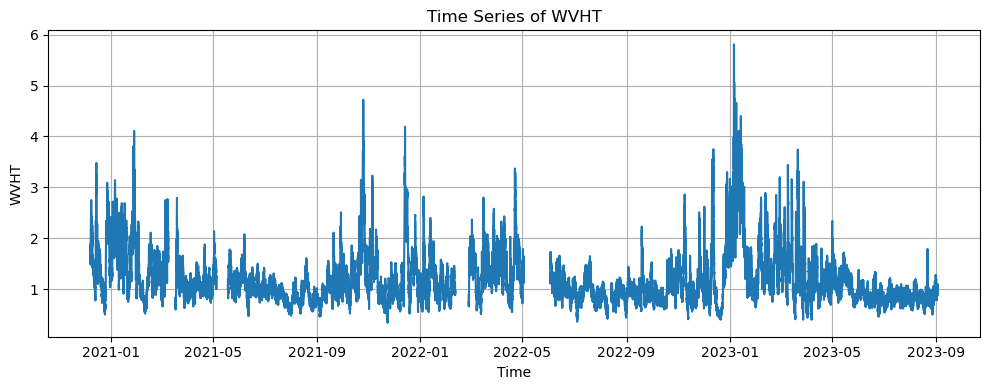

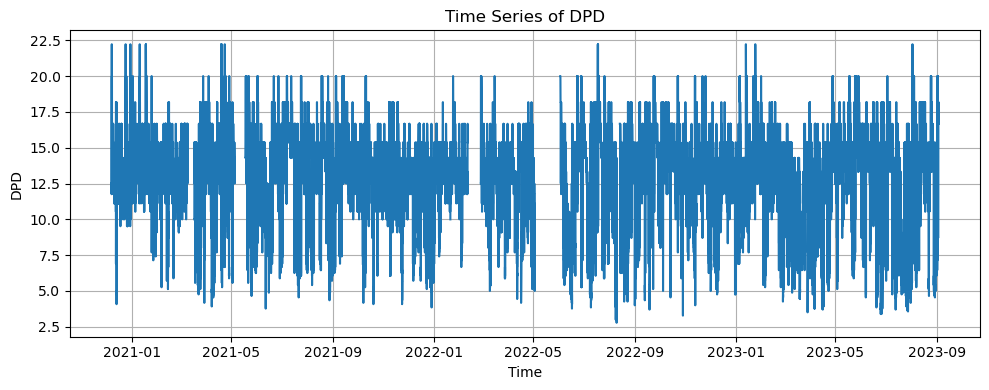

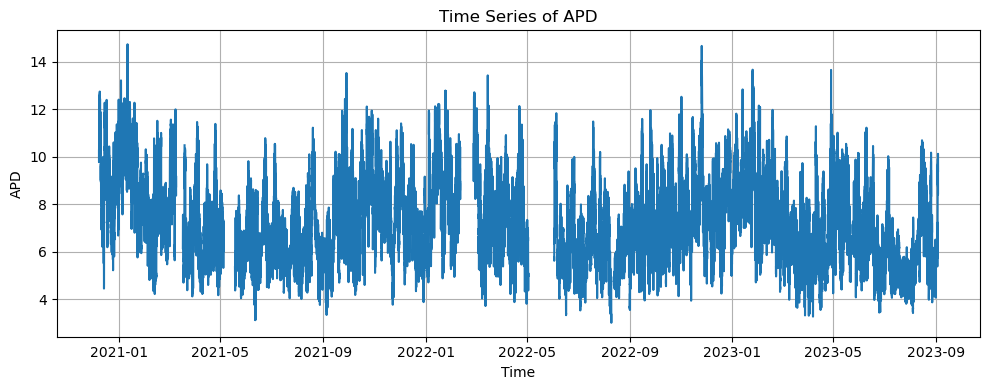

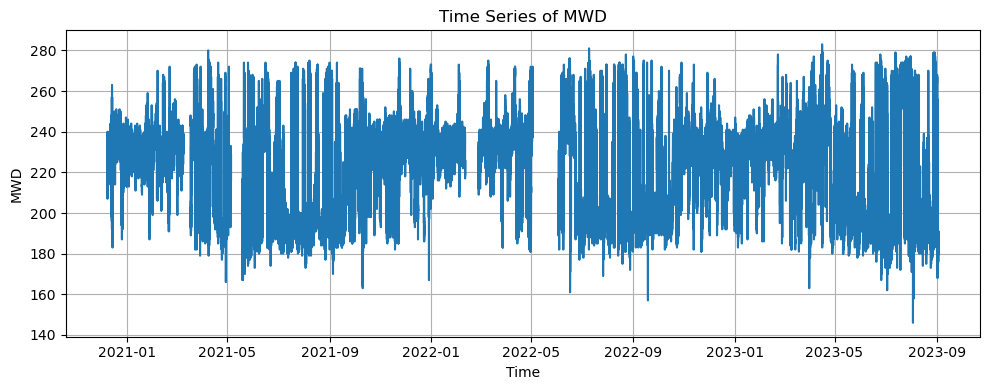

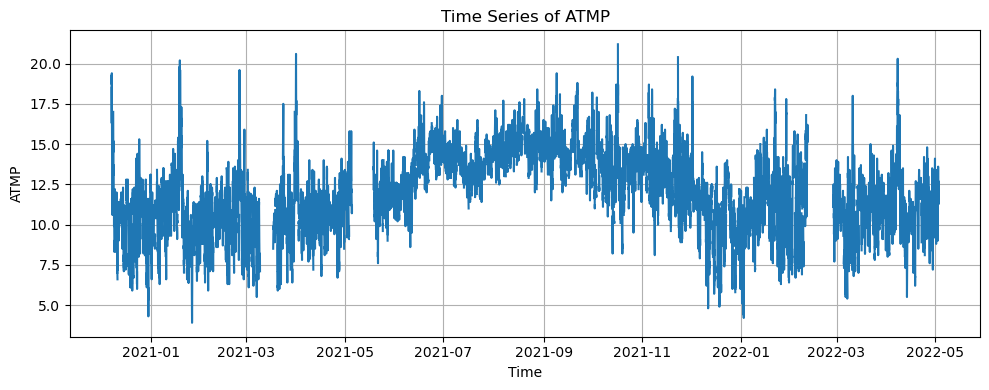

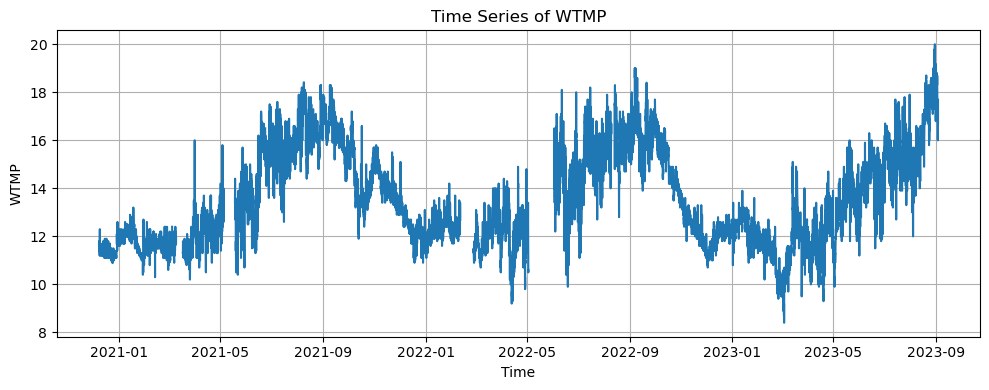

In [7]:
for col in ocean_data.columns:

    plt.figure(figsize=(10, 4))
    plt.plot(ocean_data.index, ocean_data[col])
    plt.title(f"Time Series of {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We will try to predict WVHT(wave height) given that past values of evrything. First we'll try to remove seasonality. We have seasonality of tides(24.2 hours cycle) of monthly cycle and of the year(1 year cycle), the first one we'll model with fourier terms, and the second one with a simple seasonality tools(and not both with fourier because of research saying that for CA area the wave cycles are not sinusidal, https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JC017198).
for WVHT DPD APD and MWD we will remove both tide cycle and year cycle, and for ATMP and WTMP we will remove only year cycle because of quick research at the internet

In [8]:
t = np.arange(len(ocean_data))

T = 48.4

const_dict = {}
ocean_data_s = pd.DataFrame(index=ocean_data.index)

sin_term = np.sin(2 * np.pi * t / T)
cos_term = np.cos(2 * np.pi * t / T)


fourier_df = pd.DataFrame(index=ocean_data.index, data={ 'sin': sin_term, 'cos': cos_term})

for col in ['WVHT','DPD','APD','MWD']:

    fourier_df[col] = ocean_data[col]
    valid_col_index = fourier_df[col].dropna().index

    X = add_constant(fourier_df.loc[valid_col_index,['sin','cos']])
    y_clean = fourier_df.loc[valid_col_index, col]

    model = OLS(y_clean, X).fit()
    seasonal_fit = model.predict(X)


    fourier_df[col] = y_clean - seasonal_fit
    const_dict[col] = model.params.const



for col in ['WVHT','DPD','APD','MWD']:
    ocean_data_s[f'{col}_s'] = fourier_df[col] - fourier_df[col].shift(freq = pd.DateOffset(years = 1))

for col in ['ATMP','WTMP']:
    ocean_data_s[f'{col}_s'] = ocean_data[col] - ocean_data[col].shift(freq = pd.DateOffset(years = 1))

For the next step, we will change the frequency of the data from 30-M freq to 12-H freq, that'll make the calculations easier and the data less noisy

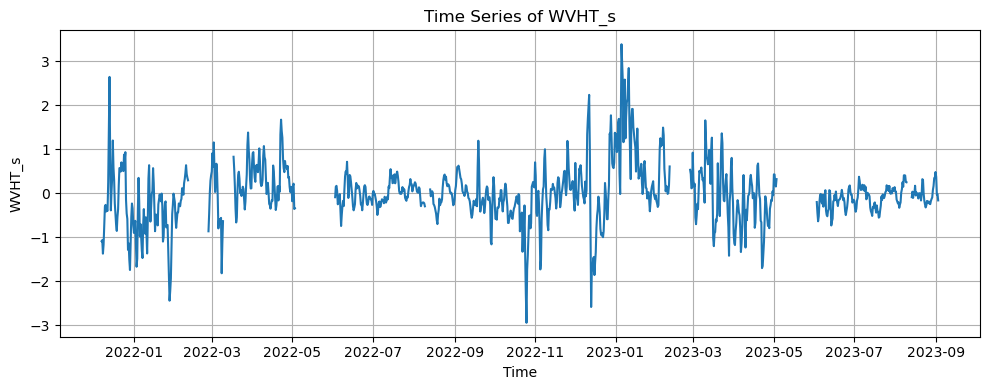

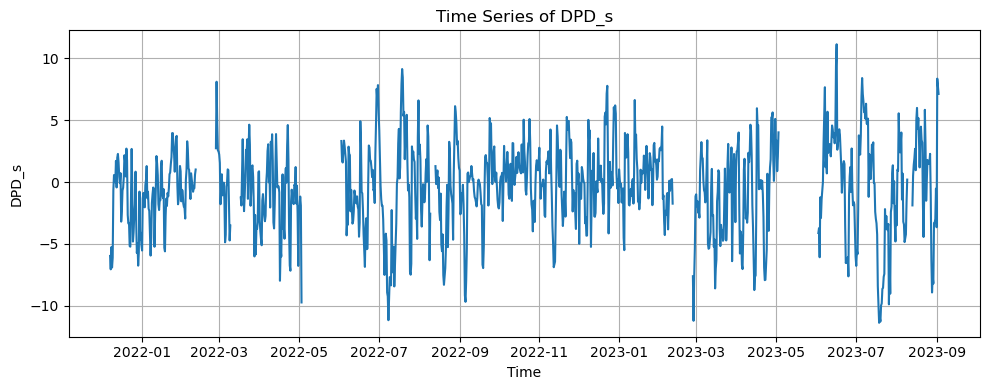

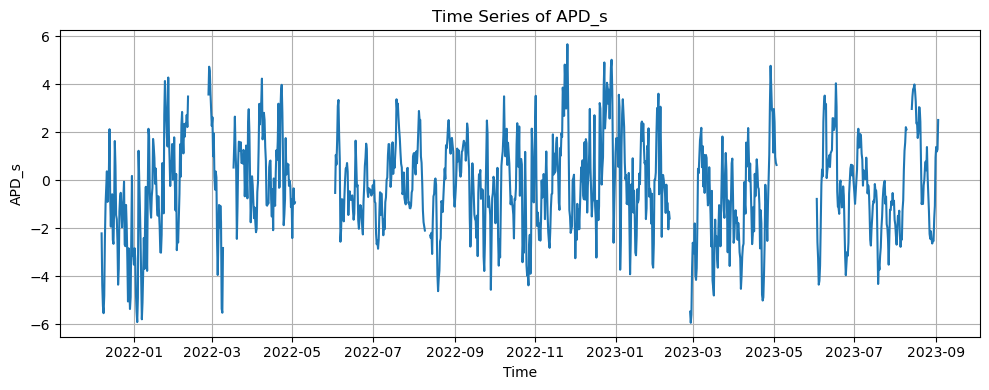

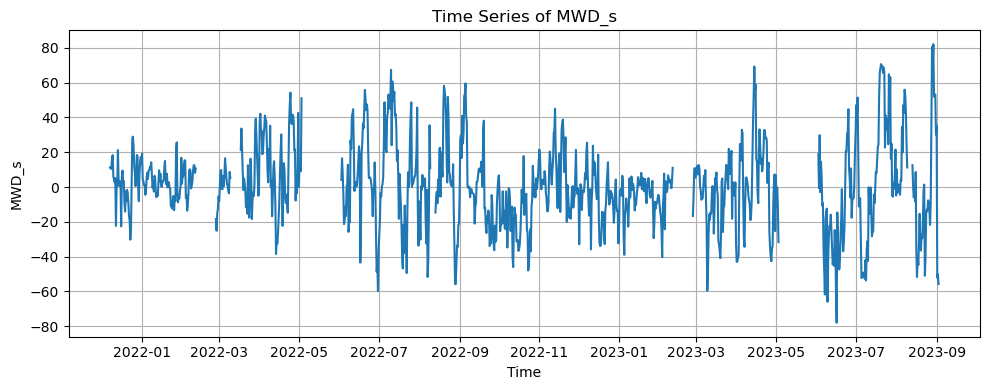

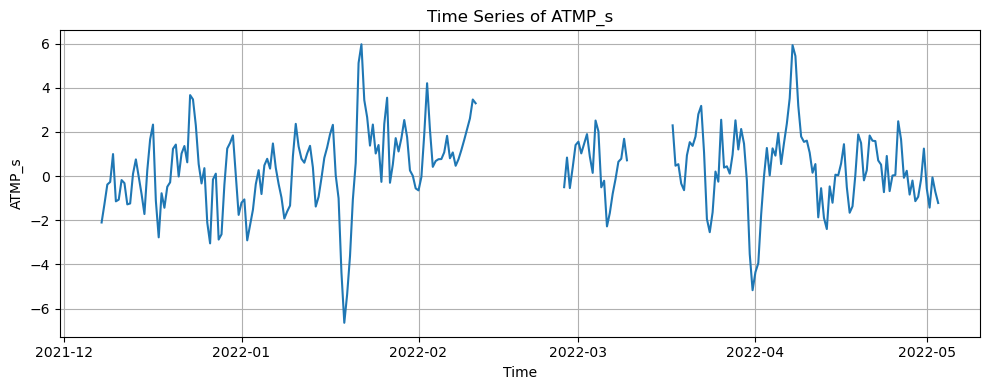

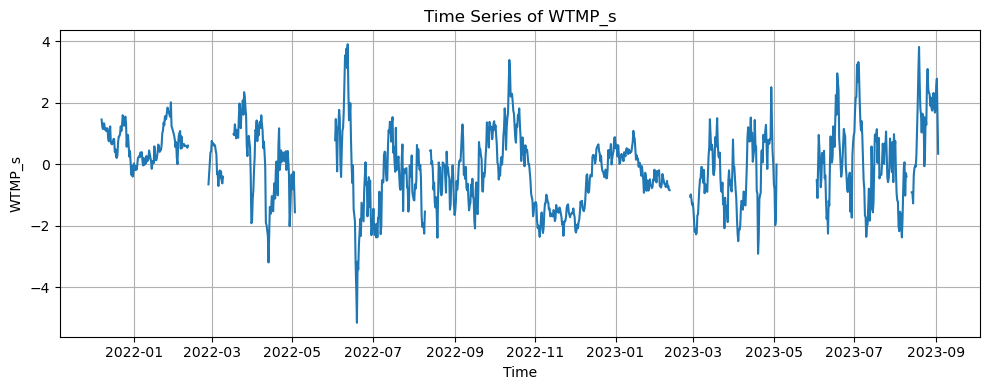

In [9]:
ocean_final = ocean_data_s.resample('12h').mean()

#plotting the data we'll work on
for col in ocean_final.columns:

    plt.figure(figsize=(10, 4))
    plt.plot(ocean_final.index, ocean_final[col])
    plt.title(f"Time Series of {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Now our next step is to look at acf and pacf, and check stationarity. For that we want to look at continuous time series, but ours have big gaps, we can see that in almost all of the variables there is a big continuous part at ~2022.6 - 2023.2 so we will look at that part, because all of the other parts are much smaller.

In [10]:
#identifying the continous areas
#dropping ATMP_s as it's too not continous
ocean_final.drop(columns=['ATMP_s'], inplace=True)

ocean_final_start = ocean_final.loc[ocean_final.index > '2022-06-02'].dropna().head(1).index.item()
ocean_final_end = ocean_final.loc[ocean_final.index < '2023-02-15'].dropna().tail(1).index.item()


ocean_final_cont =  ocean_final.loc[ocean_final_start:ocean_final_end]
print(ocean_final_cont.index[ocean_final_cont.isna().any(axis=1)])

DatetimeIndex(['2022-08-10 00:00:00', '2022-08-10 12:00:00',
               '2022-08-11 00:00:00', '2022-08-11 12:00:00',
               '2022-08-12 00:00:00', '2022-08-12 12:00:00',
               '2022-08-13 00:00:00'],
              dtype='datetime64[ns]', freq='12h')


We still have some na's, so we'll use interpolation to fill the gap since it's quite small compared to the timeframe, and this will be the data that we'll use to train the model

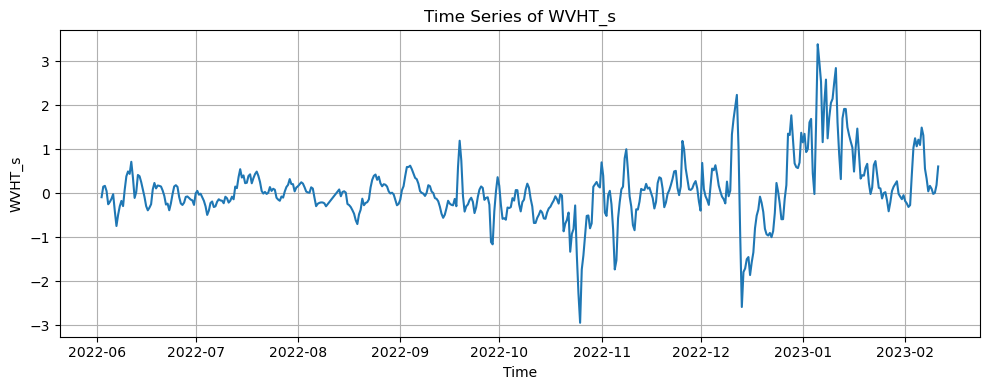

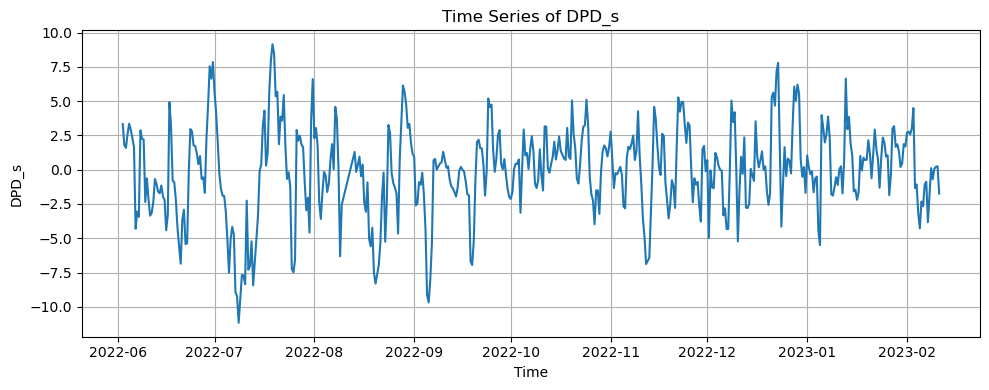

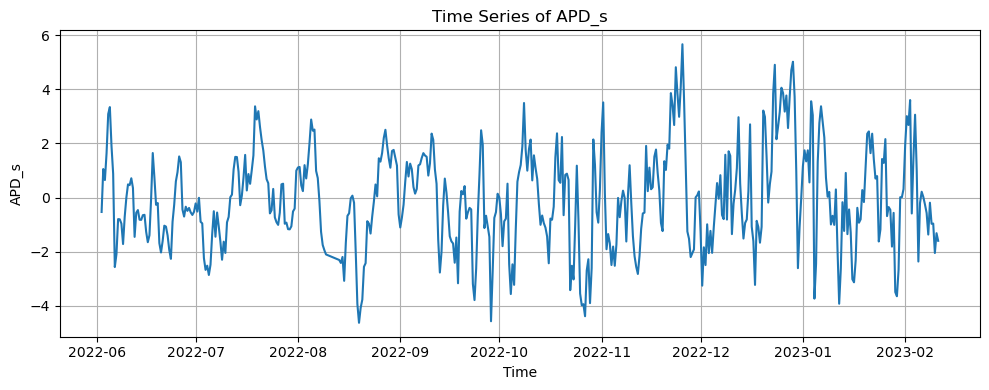

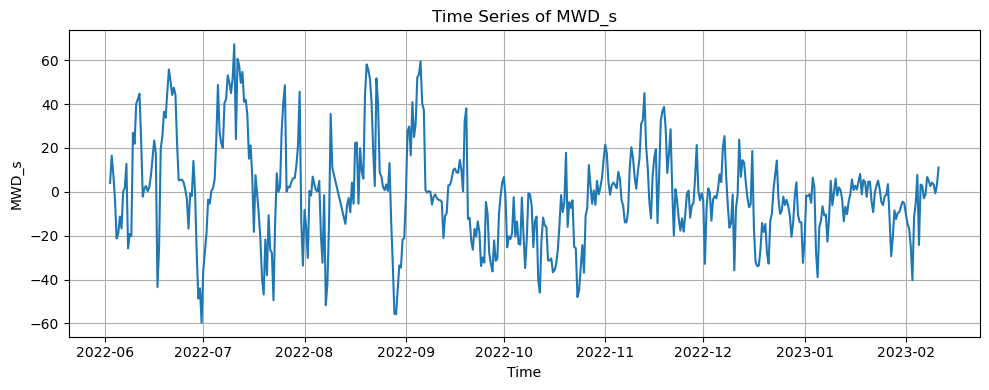

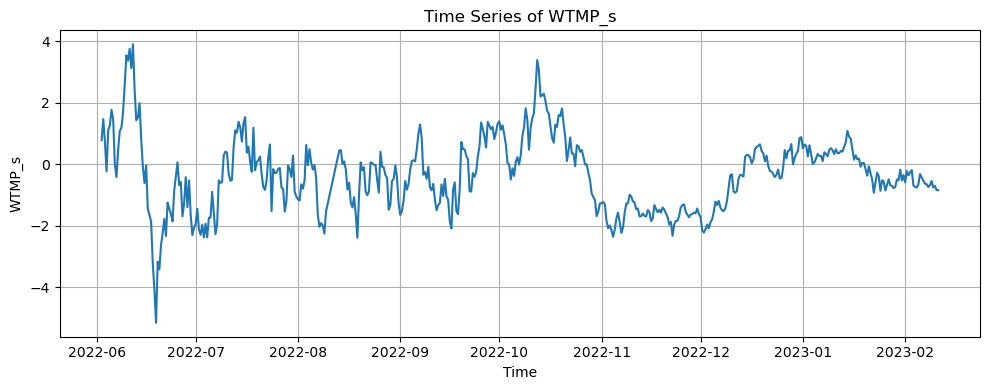

In [11]:
ocean_train = ocean_final_cont.interpolate(method='time')


#plotting it before we begin to model, to make sure everything looks fine
for col in ocean_train.columns:

    plt.figure(figsize=(10, 4))
    plt.plot(ocean_train.index, ocean_train[col])
    plt.title(f"Time Series of {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

To estimate the model, we'll first look at PACG and ACF to get a sense if an ARFIMA model would make a good choice, and check for order of integration.

In [12]:
#we'll choose order of integration with ADF tests
for col in ocean_train.columns:
    adf_res = adfuller(ocean_train[col])
    print(f'{col} p_value: {adf_res[1]}')

WVHT_s p_value: 1.6837067938181246e-05
DPD_s p_value: 1.5968928011630718e-12
APD_s p_value: 5.699762095335747e-14
MWD_s p_value: 1.0259441678787581e-08
WTMP_s p_value: 7.923648970519858e-05


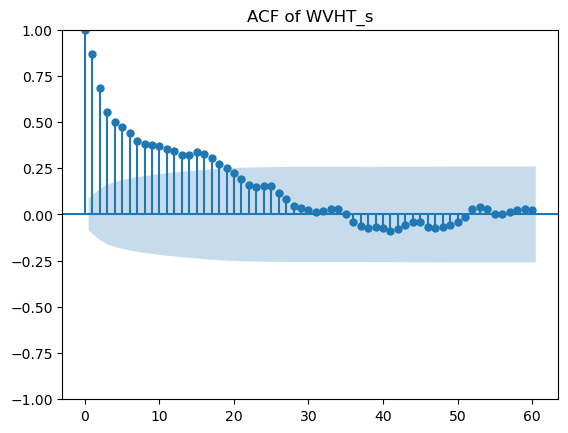

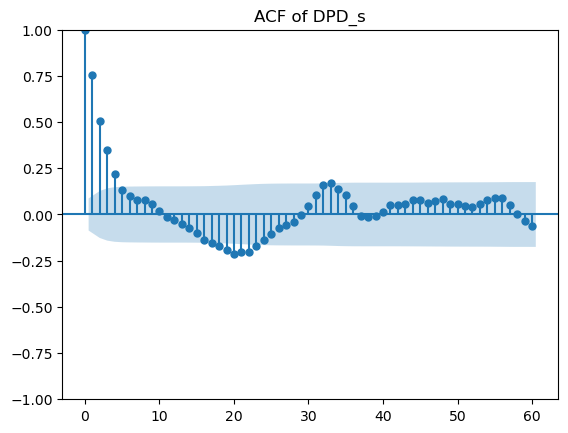

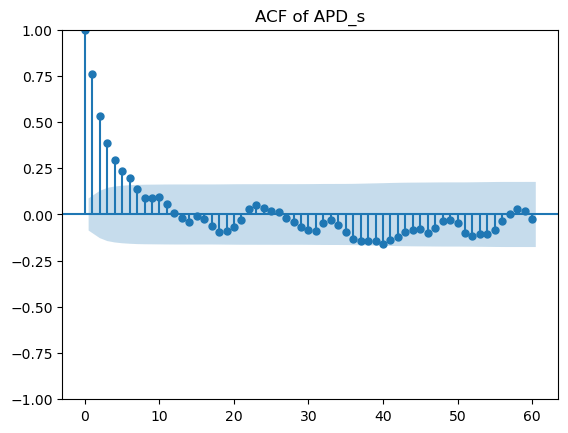

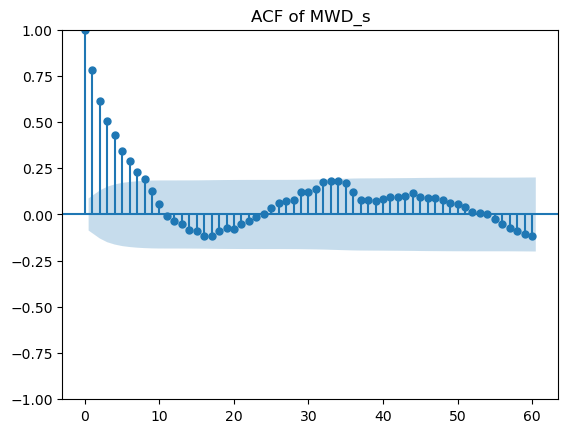

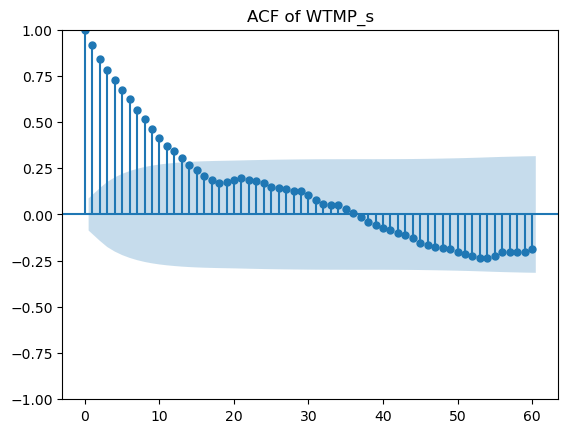

In [13]:
for col in ocean_train.columns:

    plot_acf(ocean_train[col], lags=60)
    plt.title(f"ACF of {col}")
    plt.show()

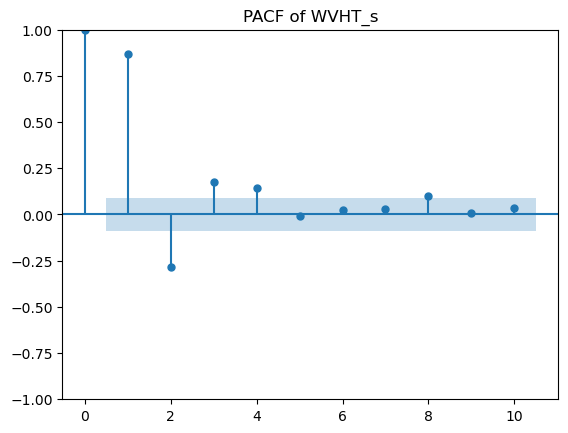

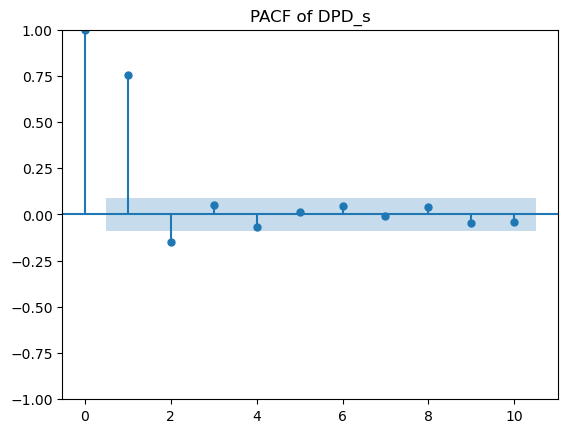

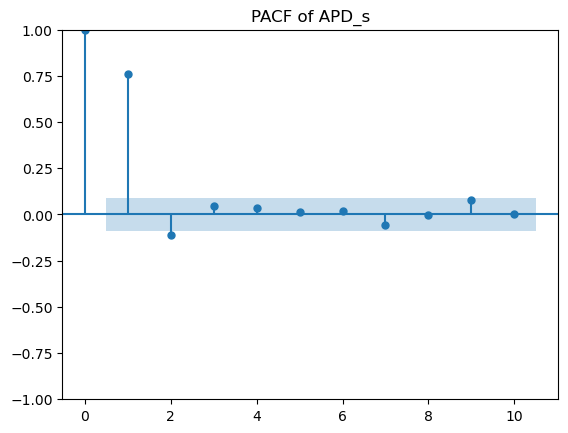

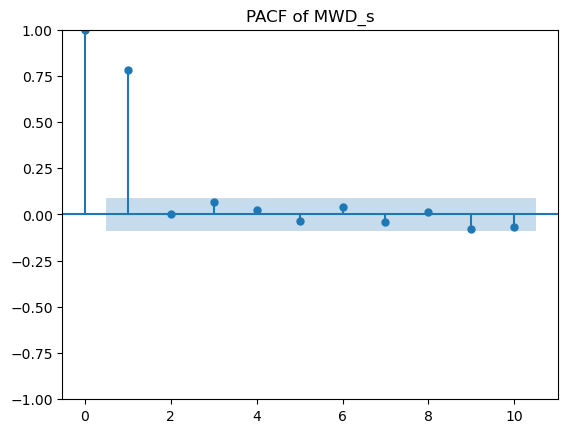

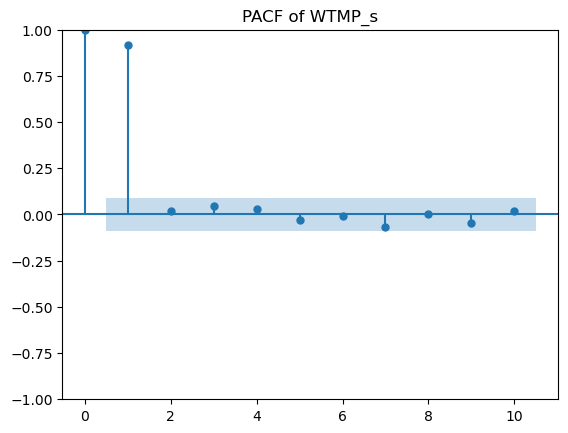

In [14]:
for col in ocean_train.columns:

    plot_pacf(ocean_train[col], lags=10)
    plt.title(f"PACF of {col}")
    plt.show()


Since our data shows strong ACF but not stationarity, we'll try to model it with ARFIMA. we'll implement fractional differencing, and then check several models AIC and BIC(not too much due to a poor student computer). all of our models will be with ma component of 0 because of the low PACF values.

From now on we'll try to focus on the wave height(WVHT)

In [15]:
#Implementing fractional diffrencing for ARFIMA estimation
def fracdiff(data, d):
    n = len(data)
    weights = [1.0]

    # Calculate weights
    for k in range(1, min(n, 10)):  # Limit to 100 terms for efficiency
        w = weights[-1] * (k - 1 - d) / k
        if abs(w) < 1e-5:  # Stop when weights get very small
            break
        weights.append(w)

    weights = np.array(weights[::-1])

    # Apply differencing
    result = []
    for i in range(len(weights)-1, n):
        result.append(np.sum(weights * data[i-len(weights)+1:i+1]))

    return np.array(result)

In [48]:
  #Initiazling objects to save resaults
d_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ar_values = range(1,10)
aic_res = pd.DataFrame(index = ar_values, columns = d_values)
bic_res = pd.DataFrame(index = ar_values, columns = d_values)

data_01 = fracdiff(ocean_train['WVHT_s'], 0.1)
data_02 = fracdiff(ocean_train['WVHT_s'], 0.2)
data_03 = fracdiff(ocean_train['WVHT_s'], 0.3)
data_04 = fracdiff(ocean_train['WVHT_s'], 0.4)
data_05 = fracdiff(ocean_train['WVHT_s'], 0.5)
data_06 = fracdiff(ocean_train['WVHT_s'], 0.6)
data_07 = fracdiff(ocean_train['WVHT_s'], 0.7)
data_08 = fracdiff(ocean_train['WVHT_s'], 0.8)
data_09 = fracdiff(ocean_train['WVHT_s'], 0.9)


#Estimating models
for ar in ar_values:


            model1 = ARIMA(data_01, order=(ar, 0, 0))
            fitted1 = model1.fit()
            aic1, bic1 = fitted1.aic, fitted1.bic


            model2 = ARIMA(data_02, order=(ar, 0, 0))
            fitted2 = model2.fit()
            aic2, bic2 = fitted2.aic, fitted2.bic


            model3 = ARIMA(data_03, order=(ar, 0, 0))
            fitted3 = model3.fit()
            aic3, bic3 = fitted3.aic, fitted3.bic


            model4 = ARIMA(data_04, order=(ar, 0, 0))
            fitted4 = model4.fit()
            aic4, bic4 = fitted4.aic, fitted4.bic


            model5 = ARIMA(data_05, order=(ar, 0, 0))
            fitted5 = model5.fit()
            aic5, bic5 = fitted5.aic, fitted5.bic


            model6 = ARIMA(data_06, order=(ar, 0, 0))
            fitted6 = model6.fit()
            aic6, bic6 = fitted6.aic, fitted6.bic


            model7 = ARIMA(data_07, order=(ar, 0, 0))
            fitted7 = model7.fit()
            aic7, bic7 = fitted7.aic, fitted7.bic


            model8 = ARIMA(data_08, order=(ar, 0, 0))
            fitted8 = model8.fit()
            aic8, bic8 = fitted8.aic, fitted8.bic


            model9 = ARIMA(data_09, order=(ar, 0, 0))
            fitted9 = model9.fit()
            aic9, bic9 = fitted9.aic, fitted9.bic


            aic_res.loc[ar,:] = [aic1, aic2, aic3, aic4, aic5, aic6, aic7, aic8, aic9]
            bic_res.loc[ar,:] = [bic1, bic2, bic3, bic4, bic5, bic6, bic7, bic8, bic9]



C:\Users\galzw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\galzw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
stacked_aic = aic_res.apply(pd.to_numeric, errors='coerce').stack()
stacked_bic = bic_res.apply(pd.to_numeric, errors='coerce').stack()

lowest_3a = stacked_aic.nsmallest(3)
lowest_3b = stacked_bic.nsmallest(3)

print(lowest_3a)
print(lowest_3b)

2  0.5    307.060272
3  0.6    307.348571
4  0.5    307.791102
dtype: float64
2  0.5    323.910696
   0.6    325.645274
   0.4    326.492730
dtype: float64


We can see that the best model is by both AIC and BIC ARFIMA(2,0.5,0), i ran the estimation model several times and the resaults was extremely consistent. let's take a look now at the sagnificant levels of it's coefficients

In [70]:
#Chosen model
model = ARIMA(data_05, order=(2, 0, 0))
fitted = model.fit()
print(fitted.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  499
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -149.530
Date:                Mon, 11 Aug 2025   AIC                            307.060
Time:                        18:52:06   BIC                            323.911
Sample:                             0   HQIC                           313.673
                                - 499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0133      0.024      0.553      0.581      -0.034       0.060
ar.L1          0.6518      0.022     29.838      0.000       0.609       0.695
ar.L2         -0.2700      0.023    -11.599      0.0

Since it looks extremly consistent we'll procced to our test data, to see if it also looks consistent there. for that we'll take 2 diffrent trst chunks, one which is more turbelent and one which is calmer.

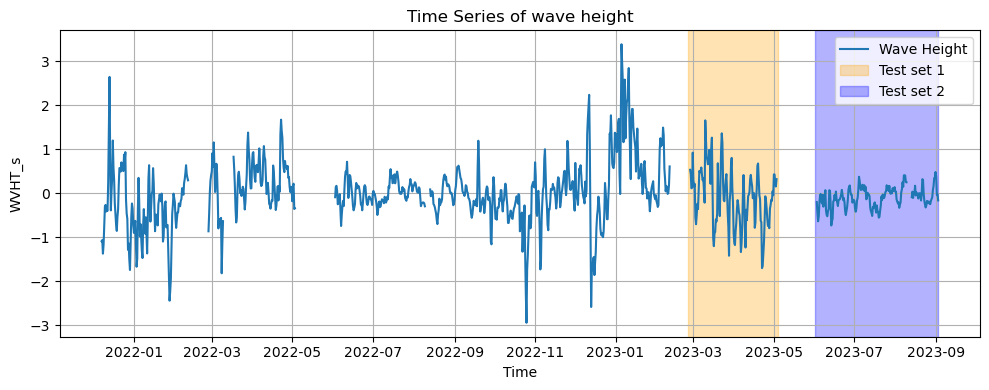

In [63]:
plt.figure(figsize=(10, 4))
plt.plot(ocean_final.index, ocean_final['WVHT_s'], label='Wave Height')


test1_start = pd.to_datetime('2023-02-25')
test1_end = pd.to_datetime('2023-05-04')

test2_start = pd.to_datetime('2023-06-01')
test2_end = pd.to_datetime('2023-09-02')

# Highlight periods with translucent color
plt.axvspan(test1_start, test1_end, color='orange', alpha=0.3, label='Test set 1')
plt.axvspan(test2_start, test2_end, color='blue', alpha=0.3, label='Test set 2')

plt.title("Time Series of wave height")
plt.xlabel("Time")
plt.ylabel('WVHT_s')  # or your variable name in col
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Now we'll predict each point on out test sets based on the 2 previous REAL samples on the test data(it would converge really fast to a constant if we did a full prediction).We will plot the resault to get an intuitive sense of how good our fitted model is.

In [79]:
#preparing the data for prediction
ocean_test1 = ocean_final.loc['2023-02-25':'2023-05-04']
ocean_test2 = ocean_final.loc['2023-06-01':'2023-09-02']

ocean_test1 = ocean_test1.interpolate(method='time')
ocean_test2 = ocean_test2.interpolate(method='time')


ocean_test1 = fracdiff(ocean_test1['WVHT_s'], 0.5)
ocean_test2 = fracdiff(ocean_test2['WVHT_s'], 0.5)

#get the estimated model coefficients
const = fitted.params[0]
phi1 = fitted.params[1]
phi2 = fitted.params[2]


#fitting a model
pred1 = []
pred2 = []


for t in range(2,len(ocean_test1)):
    prediction = ocean_test1[t - 1]*phi1 + ocean_test1[t - 2]*phi2 + const
    pred1.append(prediction)

for t in range(2,len(ocean_test2)):
    prediction = ocean_test2[t - 1]*phi1 + ocean_test2[t - 2]*phi2 + const
    pred2.append(prediction)


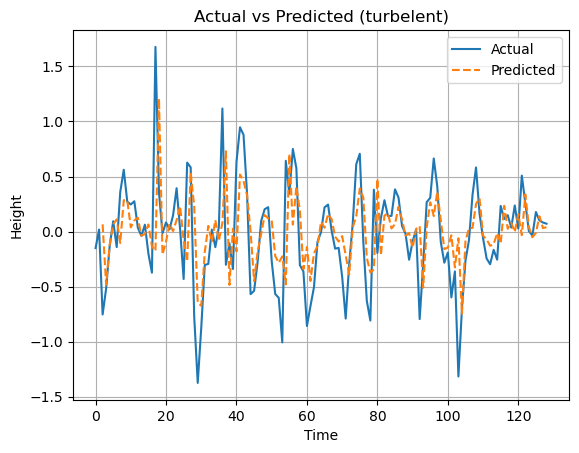

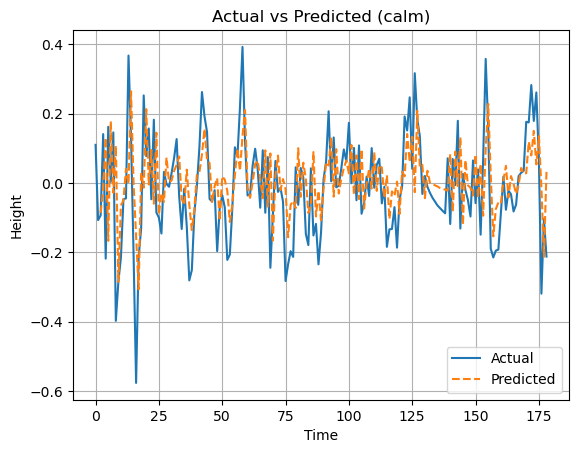

In [100]:
#plotting predictions with test data

#test set 1
# Actual values
plt.plot(range(len(ocean_test1)), ocean_test1, label='Actual')

#predicted values with offset
plt.plot(range(2, len(ocean_test1)), pred1, label='Predicted', linestyle='--')

plt.title('Actual vs Predicted (turbelent)')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()
plt.grid(True)
plt.show()


#test set 1
# Actual values
plt.plot(range(len(ocean_test2)), ocean_test2, label='Actual')

#predicted values with offset
plt.plot(range(2, len(ocean_test2)), pred2, label='Predicted', linestyle='--')

plt.title('Actual vs Predicted (calm)')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()
plt.grid(True)
plt.show()

It seems that on calmer times the prediction isn't necessarily better, but it is better when it's calmer compared to previous times. Also altough the direction is quite accurate, when we have big changes(in absoulute value) the model consistently undervalues the change.